In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearnex.cluster import KMeans
from tqdm import tqdm
import pymc3 as pm

In [2]:
def reinforce_probabilities(prob_array, SHP_i, SHP_j, alpha):
    """
    Reinforce the probabilities in a 2D array using the probabilities of each pixel's siblings.
    
    Args:
        prob_array (ndarray): A 2D array of probabilities for each pixel in the original image.
        sibling_indices (ndarray): A 3D array of indices for each pixel's siblings in the original image.
        alpha (float): A weighting factor between 0 and 1 that determines the relative importance of the
            pixel's probability versus the average probability of its siblings.
    
    Returns:
        A new 2D array of reinforced probabilities.
    """
    
    prob_with_siblings = np.empty(shape=SHP_i.shape, dtype=float)
    sib_mask = ~np.isnan(SHP_i) * ~np.isnan(SHP_j)
    n_siblings = np.sum(sib_mask, axis=0)

    alpha = 1/n_siblings

    prob_with_siblings[sib_mask] = probabilities[SHP_i[sib_mask].astype(int), SHP_j[sib_mask].astype(int)]
    prob_with_siblings[~sib_mask] = np.nan

    sibling_prob = np.nanmean(prob_with_siblings, axis=0)
    # sibling_prob = 1 - np.nanprod(1 - prob_with_siblings[1:], axis=0) # Probability that at least one sib has changed

    # reinforced_prob = prob_array * sibling_prob

    reinforced_prob = alpha * prob_array + (1-alpha) * sibling_prob

    return reinforced_prob

In [3]:
def reinforce_probabilities_prod(prob_array, SHP_i, SHP_j, alpha):
    """
    Reinforce the probabilities in a 2D array using the probabilities of each pixel's siblings.
    
    Args:
        prob_array (ndarray): A 2D array of probabilities for each pixel in the original image.
        sibling_indices (ndarray): A 3D array of indices for each pixel's siblings in the original image.
        alpha (float): A weighting factor between 0 and 1 that determines the relative importance of the
            pixel's probability versus the average probability of its siblings.
    
    Returns:
        A new 2D array of reinforced probabilities.
    """
    
    prob_with_siblings = np.empty(shape=SHP_i.shape, dtype=float)
    sib_mask = ~np.isnan(SHP_i) * ~np.isnan(SHP_j)
    n_siblings = np.sum(sib_mask, axis=0)

    alpha = 1/n_siblings

    prob_with_siblings[sib_mask] = probabilities[SHP_i[sib_mask].astype(int), SHP_j[sib_mask].astype(int)]
    prob_with_siblings[~sib_mask] = np.nan

    sibling_prob = 1 - np.nanprod(1 - prob_with_siblings[1:], axis=0) # Probability that at least one sib has changed

    # reinforced_prob = prob_array * sibling_prob

    reinforced_prob = alpha * prob_array + (1-alpha) * sibling_prob

    return reinforced_prob

In [4]:
def reinforce_probabilities_bayes(prob_array, SHP_i, SHP_j, prior_alpha, prior_beta):
    """
    Reinforce the probabilities in a 2D array using Bayesian modeling that incorporates the probabilities
    of each pixel's siblings.
    
    Args:
        prob_array (ndarray): A 2D array of probabilities for each pixel in the original image.
        SHP_i (ndarray): A 3D array of indices for each pixel's siblings in the original image across the j dimension.
        SHP_j (ndarray): A 3D array of indices for each pixel's siblings in the original image across the i dimension.
        alpha (float): A weighting factor between 0 and 1 that determines the relative importance of the
            pixel's probability versus the average probability of its siblings.
        prior_alpha (float): The alpha parameter of the prior beta distribution for the pixel probabilities.
        prior_beta (float): The beta parameter of the prior beta distribution for the pixel probabilities.
    
    Returns:
        A new 2D array of reinforced probabilities.
    """
    # Define the prior distribution for the pixel probabilities
    # prior_dist = pm.Beta.dist(alpha=prior_alpha, beta=prior_beta)
    prior_dist = pm.floatX(np.mean(prob_array))

    # Initialize output array
    reinforced_probs = np.zeros_like(prob_array)

    i_ix, j_ix = np.mgrid[0:prob_array.shape[0], 0:prob_array.shape[1]]
    
    prob_with_siblings = np.empty(shape=SHP_i.shape, dtype=float)
    sib_mask = ~np.isnan(SHP_i) * ~np.isnan(SHP_j)
    n_siblings = np.sum(sib_mask, axis=0)

    prob_with_siblings[sib_mask] = probabilities[SHP_i[sib_mask].astype(int), SHP_j[sib_mask].astype(int)]
    prob_with_siblings[~sib_mask] = np.nan

    for ix in tqdm(range(i_ix.size)):
        i, j = i_ix.flatten()[ix], j_ix.flatten()[ix]

        # Define the prior distribution for the sibling probabilities
        prior_sibling_dist = pm.Beta.dist(alpha=prior_alpha, beta=prior_beta)
        prior_dist = pm.Beta('prior', alpha=alpha, beta=beta)

        # Define the likelihood function for the pixel probability
        likelihood = pm.Bernoulli('likelihood', p=prior_dist, observed=prob_array[i, j])
        
        # Define the likelihood function for the sibling probabilities
        sibling_likelihood = pm.Beta('sibling_likelihood', alpha=prior_sibling_dist.alpha + n_siblings[i, j] * alpha,
                                        beta=prior_beta + n_siblings[i, j] * (1-alpha),
                                        observed=np.nanmean(prob_with_siblings[i, j]))
        
        # Compute posterior distribution for the pixel probability
        posterior_dist = pm.Beta('posterior', alpha=prior_dist.alpha + likelihood.sum(),
                                    beta=prior_dist.beta + likelihood.size - likelihood.sum())
        
        # Sample from the posterior distribution
        trace = pm.sample(1000, tune=1000)
        
        # Compute the weighted average of the pixel and sibling probabilities
        reinforced_probs[i, j] = alpha * trace['posterior'].mean() + (1-alpha) * sibling_likelihood.distribution.mean()

    # prob_with_siblings = np.empty(shape=SHP_i.shape, dtype=float)
    # sib_mask = ~np.isnan(SHP_i) * ~np.isnan(SHP_j)

    # prob_with_siblings[sib_mask] = probabilities[SHP_i[sib_mask].astype(int), SHP_j[sib_mask].astype(int)]
    # prob_with_siblings[~sib_mask] = np.nan

    # sibling_prob = np.nanmean(prob_with_siblings, axis=0)

    # reinforced_prob = alpha * prob_array + (1-alpha) * sibling_prob

    return reinforced_probs

### Non-bayes approach

In [5]:
probabilities = 1 - np.load("timeseries/probabilities_100_101_20230221_202044.npy")

wdir = "/nfs/a1/homes/py15jmc/"

SHP_i = np.load(wdir + "bootstrap/shp_i_20150511_20170617.npy")
SHP_j = np.load(wdir + "bootstrap/shp_j_20150511_20170617.npy")

In [6]:
alpha = 0.2
r = reinforce_probabilities(probabilities, SHP_i, SHP_j, alpha)
r_prod = reinforce_probabilities_prod(probabilities, SHP_i, SHP_i, alpha)

0.9892950028864693
0.013318959837047777


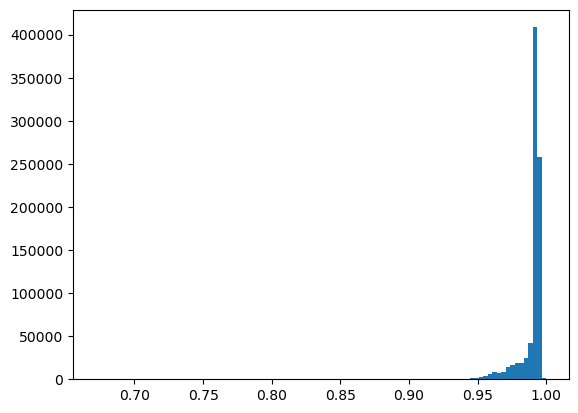

In [10]:
plt.hist(r_prod.flatten(), bins=100);
print (np.mean(r_prod))
print (np.std(r_prod))

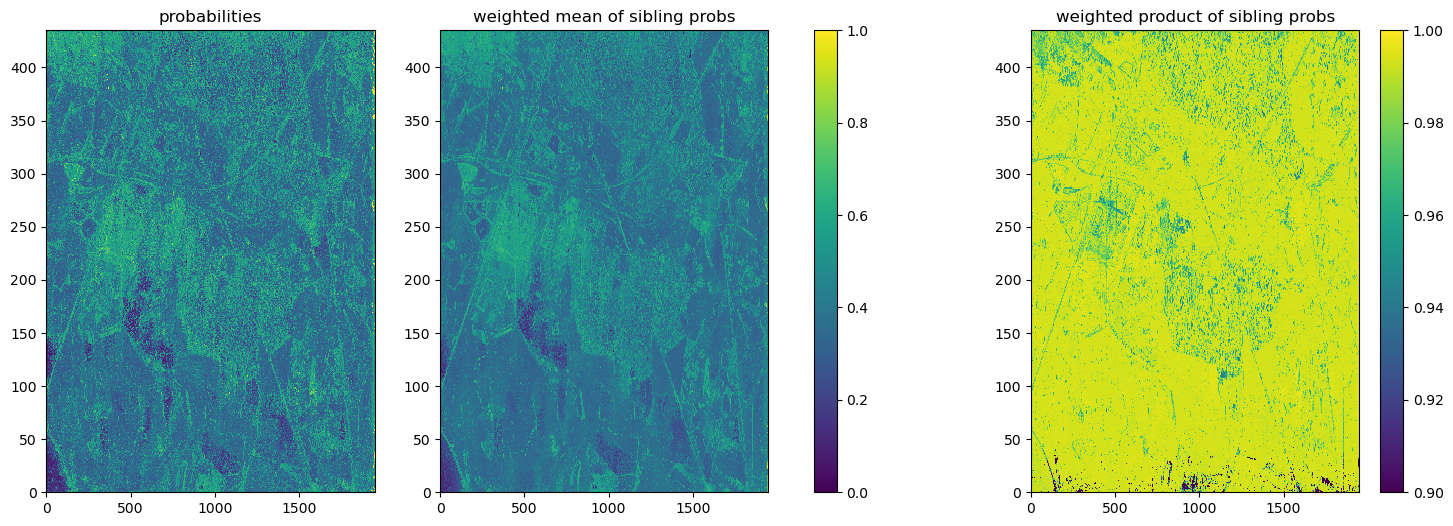

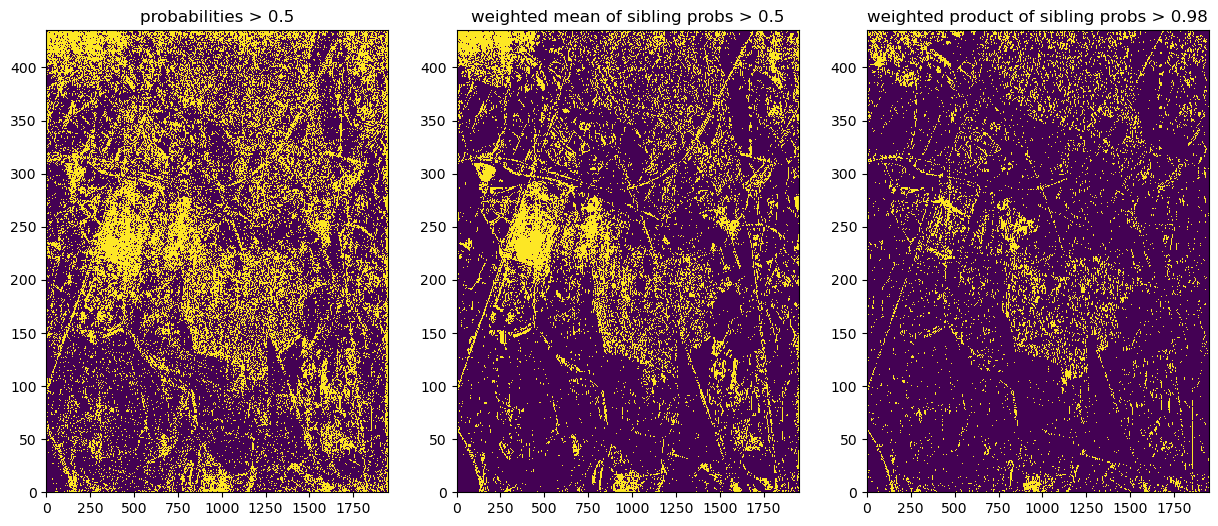

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(18, 6))

p = ax[0].pcolormesh(probabilities, vmin=0, vmax=1)
ax[1].pcolormesh(r, vmin=0, vmax=1)
plt.colorbar(p, ax=ax[:-1])

p2 = ax[2].pcolormesh(r_prod, vmin=0.9, vmax=1)
plt.colorbar(p2, ax=ax[2])

ax[0].set_title("probabilities")
ax[1].set_title("weighted mean of sibling probs")
ax[2].set_title("weighted product of sibling probs")

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 6))

ax[0].pcolormesh(probabilities > 0.5, vmin=0, vmax=1)
# ax[1].pcolormesh((r > 0.5) & (probabilities > 0.5), vmin=0, vmax=1)
ax[1].pcolormesh((r > 0.5), vmin=0, vmax=1)
ax[2].pcolormesh((r_prod < 0.98), vmin=0, vmax=1)

ax[0].set_title("probabilities > 0.5")
ax[1].set_title("weighted mean of sibling probs > 0.5")
ax[2].set_title("weighted product of sibling probs > 0.98")

plt.show()

Text(0.5, 1.0, 'Weighted mean prob')

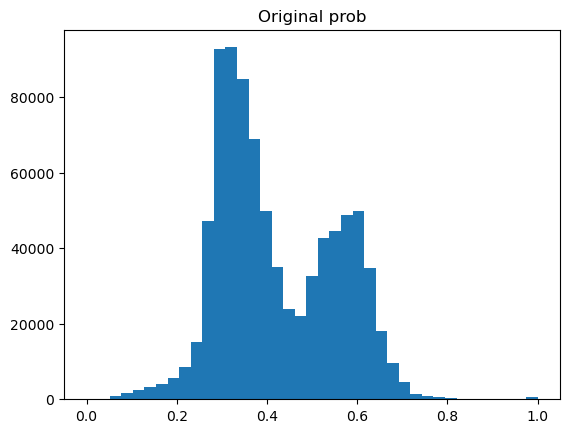

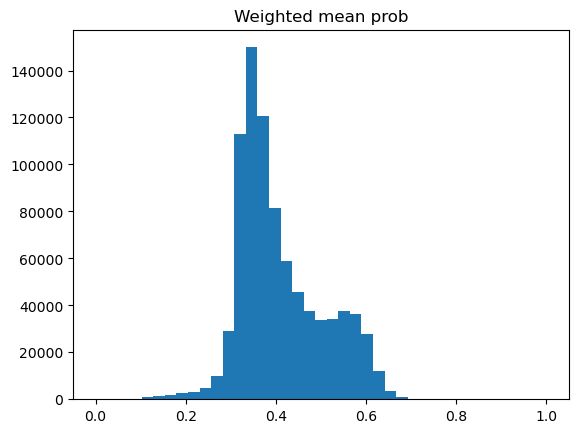

In [51]:
plt.hist(probabilities.flatten(), bins=np.linspace(0, 1, 40))
plt.title("Original prob")
plt.figure()
plt.hist(r.flatten(), bins=np.linspace(0, 1, 40))
plt.title("Weighted mean prob")

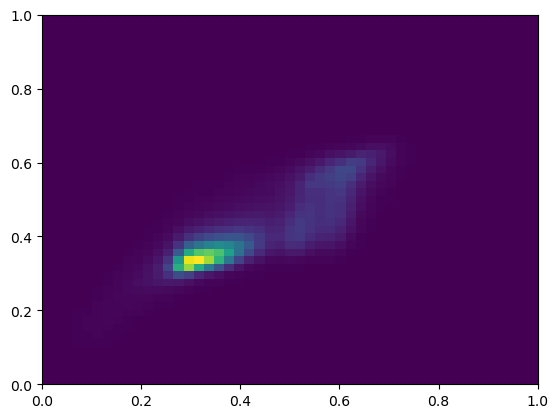

In [53]:
plt.hist2d(probabilities.flatten(), r.flatten(), bins=np.linspace(0, 1, 50));

In [14]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(np.stack((probabilities.flatten(), r.flatten())).T)

m = 0.5025468112638591
lo = 0.34820109548113576
hi = 0.6568925270465825


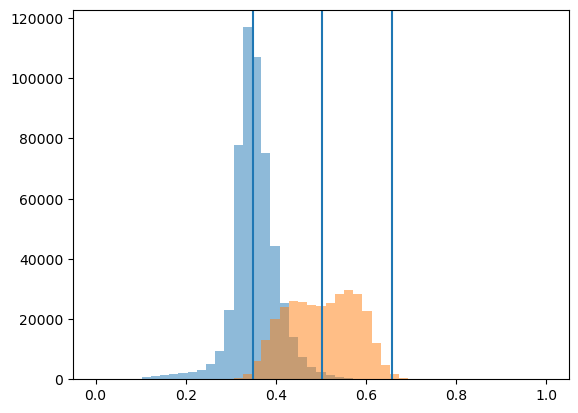

In [55]:
plt.hist(r.flatten()[kmeans.labels_ == 0], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(r.flatten()[kmeans.labels_ == 1], bins=np.linspace(0, 1, 50), alpha=0.5)

lo = np.mean(r.flatten()[kmeans.labels_ == 1]) - 2*np.std(r.flatten()[kmeans.labels_ == 1])
m = np.mean(r.flatten()[kmeans.labels_ == 1])
hi = np.mean(r.flatten()[kmeans.labels_ == 1]) + 2*np.std(r.flatten()[kmeans.labels_ == 1])

plt.axvline(x = m)
print (f"{m = }")

plt.axvline(x = lo)
print (f"{lo = }")

plt.axvline(x = hi)
print ( f"{hi = }")

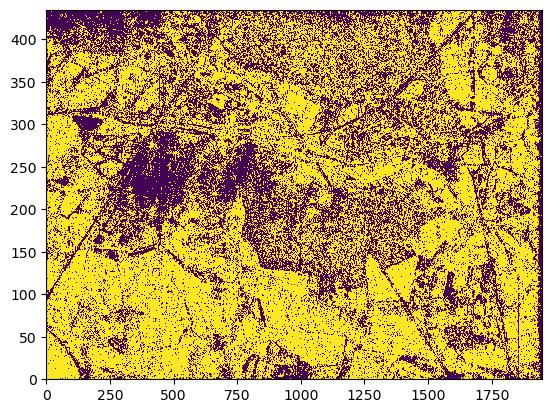

In [16]:
plt.pcolormesh(((kmeans.labels_) == 0).reshape(probabilities.shape))

### Bayes approach

In [74]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(np.stack((probabilities.flatten(), r.flatten())).T).labels_.reshape(probabilities.shape)

m = np.mean(probabilities[kmeans == 1])
v = np.std(probabilities[kmeans == 1])**2

alpha = m**2 / v
beta = m / v

print (f"{alpha = }, {beta = }")

alpha = 73.27308763204026, beta = 128.77609814122906


In [80]:
bayes_approach = reinforce_probabilities_bayes(probabilities, SHP_i, SHP_j, alpha, beta)

  0%|          | 0/847815 [00:00<?, ?it/s]


AttributeError: 'numpy.float64' object has no attribute 'alpha'